In [1]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
import io
import requests 
from bs4 import BeautifulSoup
import time
from matplotlib.lines import Line2D
import os
import csv
from os import listdir
from scipy import ndimage
from scipy import stats
from scipy import signal
from HPGe import *

In [3]:
marker_list = list(Line2D.markers.keys())

In [2]:
Spectra().df

,Filename,Live time/s,Real time/s,Total CPS
0,Background_16_10_23_Mon_14_50.csv,353069.86,354394.61,1.041791
1,HPGe_21.02.2022_background.csv,1204602.50,1209121.82,2.596276
2,HPGe_Background_12.12.23.csv,411527.06,413117.24,1.946662
3,HPGe_Sample3_07.12.23.csv,777953.97,780963.11,0.447947
4,IAEA_Sample_20_11_23_Mon_10_58.csv,589490.43,591717.78,0.668286
5,IAEA_sample_05.12.22 copy.csv,1191067.75,1195547.14,4.114920
6,Sample1_23_10_23_Mon_10_39.csv,586551.55,588791.75,4.144091
7,Sample2_31_10_23_14_08.csv,690516.01,693190.81,4.447199
8,Sample3_07_11_23_Tue_11_50.csv,592161.76,594479.48,2.488062
9,Sample4_13_11_23_Mon_14_06.csv,523881.40,525880.09,4.665623


In [34]:
def err_prop(data,err):
    '''Error propagation for effect of rescaling sample 3 data'''
    S_err_S = Spec(3).S_err/Spec(3).S
    err_data = err/data
    return data*Spec(3).S * np.sqrt(S_err_S**2 + err_data**2)



### Create DataFrame of all peaks csv files of different spectra
Order: background (12/12/2023), samples 1-4, IAEA385 (2022)

In [109]:
pk_path_ls = sorted(listdir('Data/Peaks_final'))[1:] #peak csv path list
#concat all modified peak dataframe
pk_path_ls = [pk_path_ls[1]] + pk_path_ls[2:] + [pk_path_ls[0]] #reorder such that: bg, sample 1-4, iaea
df = pd.concat([peak_df_new(peak_df('Data/Peaks_final/'+path)) for path in pk_path_ls],keys = range(len(pk_path_ls)))

#rescale sample 3
df.loc[3,['Net_Area_Count','Peak_CPS','Peak_CPS_BR']] = df.loc[3,['Net_Area_Count','Peak_CPS','Peak_CPS_BR']].values * Spec(3).S
df.loc[3,'Net_Area_err'] = err_prop(df.loc[3,'Net_Area_Count'].values,df.loc[3,'Net_Area_err'].values)


In [24]:
iaea_df = df.loc[5]
bg_df = df.loc[0]

### Efficiency Calibration using IAEA385 Sample

In [110]:
#Cs activity is corrected for half life
iaea_385 =pd.read_csv('IAEA385_ReferenceActivity_2019.csv',delimiter = ',') 
iaea_mass = 0.05 #kg
#merge activity to iaea peak df
iaea_df = df.loc[5].merge(iaea_385,on='Nuclide')
#peak background correction
#merge peak background dataframe with iaea peak dataframe
iaea_df = iaea_df.merge(df.loc[0][['nndc_peak_energy','Peak_CPS_BR']], on = 'nndc_peak_energy', 
how = 'left', suffixes = ['','_bg']) #df.loc[0] contains background peaks
iaea_df['Peak_CPS_BR_bg'].fillna(0,inplace = True)
#corrected count per sec/BR
iaea_df['Peak_CPS_BR_corr'] = iaea_df['Peak_CPS_BR']-iaea_df['Peak_CPS_BR_bg']
iaea_df['eff'] = iaea_df['Peak_CPS_BR_corr']/(iaea_df['Abs_Activity']*iaea_mass) #efficiency
#error propagation (assume poisson noise for peak cps error)
iaea_df['eff_err']=iaea_df['eff']* np.sqrt((iaea_df['Net_Area_err']/iaea_df['Net_Area_Count'])**2+
(iaea_df['Abs_Activity_Unc']/iaea_df['Abs_Activity'])**2 + 0.05**2) #0.05**2 from percentage error of mass

df = pd.concat([df.loc[i].merge(iaea_df[['nndc_peak_energy','Peak_CPS_BR_bg','eff','eff_err']],on = 'nndc_peak_energy',how = 'left')
     for i in range(len(pk_path_ls))],keys = range(len(pk_path_ls)))


In [111]:
df

Photopeak_Energy  Centroid Nuclide  Net_Area_Count  Net_Area_err  \
0 0             242.00    242.44   Pb214           405.1          80.4   
  1             295.24    295.59   Pb214           679.2          62.6   
  2             351.93    352.43   Pb214          1079.4          56.5   
  3             609.31    609.84   Bi214           832.3          41.3   
  4             768.36    769.08   Bi214            59.4          20.9   
...                ...       ...     ...             ...           ...   
5 56           1847.42   1847.47   Bi214           483.4          36.3   
  57           2118.55   2118.59   Bi214           339.9          35.2   
  58           2204.21   2203.88   Bi214          1069.4          44.2   
  59           2447.86   2447.86   Bi214           307.6          40.0   
  60           2614.53   2614.82   Tl208          8883.1          96.9   

      Peak_CPS  FWHM  Reduced_chi2  rounded_energy    nuc  ...      BR_err  \
0 0   0.000981  1.36          3.69           242.0  Pb214  ...       3e-05   
  1   0.001644  1.20          1.71           295.0  Pb214  ...       5e-05   
  2   0.002613  1.19          1.72           352.0  Pb214  ...       9e-05   
  3   0.002015  1.33          3.09           609.0  Bi214  ...               
  4   0.000144  1.00          0.85           768.0  Bi214  ...  0.03E-5      
...        ...   ...           ...             ...    ...  ...         ...   
5 56  0.000404  2.05          1.47          1847.0  Bi214  ...  0.14E-6      
  57  0.000284  2.65          0.89          2119.0  Bi214  ...  0.13E-7      
  58  0.000894  2.07          0.51          2204.0  Bi214  ...  0.05E-6      
  59  0.000257  2.50          0.66          2448.0  Bi214  ...  0.03E-7      
  60  0.007430  2.54          1.66          2615.0  Tl208  ...       5e-07   

      T1/2(s)  Centroid_err  FWHM_err  Resolution  Resolution_err  \
0 0   1623.60      0.028695  0.047780    0.005610        0.000197   
  1   1623.60      0.019554  0.032559    0.004060        0.000110   
  2   1623.60      0.015381  0.025612    0.003377        0.000073   
  3   1182.60      0.019577  0.032598    0.002181        0.000053   
  4   1182.60      0.055100  0.091747    0.001300        0.000119   
...       ...           ...       ...         ...             ...   
5 56  1182.60      0.039595  0.065930    0.001110        0.000036   
  57  1182.60      0.061040  0.101638    0.001251        0.000048   
  58  1182.60      0.026881  0.044760    0.000939        0.000020   
  59  1182.60      0.060533  0.100793    0.001021        0.000041   
  60   183.18      0.011444  0.019056    0.000971        0.000007   

      Peak_CPS_BR  Peak_CPS_BR_bg       eff   eff_err  
0 0      0.013508        0.013508  0.076903  0.008448  
  1      0.008901        0.008901  0.046778  0.005112  
  2      0.007315        0.007315  0.042854  0.004663  
  3      0.004434        0.004434  0.027355  0.003130  
  4      0.002942        0.002942  0.023173  0.002892  
...           ...             ...       ...       ...  
5 56     0.019946        0.005024  0.015227  0.002080  
  57     0.024591        0.009117  0.015790  0.002433  
  58     0.018180        0.006702  0.011712  0.001421  
  59     0.016655        0.004154  0.012756  0.002207  
  60     0.007449        0.001604  0.010077  0.001540  

[317 rows x 23 columns]

In [113]:
df['Peak_CPS_BR']-df['Peak_CPS_BR_bg']

0  0     0.000000
   1     0.000000
   2     0.000000
   3     0.000000
   4     0.000000
           ...   
5  56    0.014923
   57    0.015474
   58    0.011478
   59    0.012501
   60    0.005844
Length: 317, dtype: float64

In [114]:
sample_mass = np.array([0.427-0.0583, 0.5733-0.0576,0.5399-0.0581,0.5585-0.0581 ])
live_time = np.array(Spec(0).live_time)
df['Peak_CPS_BR_corr'] = df['Peak_CPS_BR']-df['Peak_CPS_BR_bg']
df['pseudo_A'] = df['Peak_CPS_BR_corr']/df['eff']
df['pseudo_A_err'] = df['pseudo_A']*np.sqrt((df['Net_Area_err']/df['Net_Area_Count'])**2+(df['eff_err']/df['eff'])**2)
df

Photopeak_Energy  Centroid Nuclide  Net_Area_Count  Net_Area_err  \
0 0             242.00    242.44   Pb214           405.1          80.4   
  1             295.24    295.59   Pb214           679.2          62.6   
  2             351.93    352.43   Pb214          1079.4          56.5   
  3             609.31    609.84   Bi214           832.3          41.3   
  4             768.36    769.08   Bi214            59.4          20.9   
...                ...       ...     ...             ...           ...   
5 56           1847.42   1847.47   Bi214           483.4          36.3   
  57           2118.55   2118.59   Bi214           339.9          35.2   
  58           2204.21   2203.88   Bi214          1069.4          44.2   
  59           2447.86   2447.86   Bi214           307.6          40.0   
  60           2614.53   2614.82   Tl208          8883.1          96.9   

      Peak_CPS  FWHM  Reduced_chi2  rounded_energy    nuc  ...  Resolution  \
0 0   0.000981  1.36          3.69           242.0  Pb214  ...    0.005610   
  1   0.001644  1.20          1.71           295.0  Pb214  ...    0.004060   
  2   0.002613  1.19          1.72           352.0  Pb214  ...    0.003377   
  3   0.002015  1.33          3.09           609.0  Bi214  ...    0.002181   
  4   0.000144  1.00          0.85           768.0  Bi214  ...    0.001300   
...        ...   ...           ...             ...    ...  ...         ...   
5 56  0.000404  2.05          1.47          1847.0  Bi214  ...    0.001110   
  57  0.000284  2.65          0.89          2119.0  Bi214  ...    0.001251   
  58  0.000894  2.07          0.51          2204.0  Bi214  ...    0.000939   
  59  0.000257  2.50          0.66          2448.0  Bi214  ...    0.001021   
  60  0.007430  2.54          1.66          2615.0  Tl208  ...    0.000971   

     Resolution_err  Peak_CPS_BR Peak_CPS_BR_bg       eff   eff_err  \
0 0        0.000197     0.013508       0.013508  0.076903  0.008448   
  1        0.000110     0.008901       0.008901  0.046778  0.005112   
  2        0.000073     0.007315       0.007315  0.042854  0.004663   
  3        0.000053     0.004434       0.004434  0.027355  0.003130   
  4        0.000119     0.002942       0.002942  0.023173  0.002892   
...             ...          ...            ...       ...       ...   
5 56       0.000036     0.019946       0.005024  0.015227  0.002080   
  57       0.000048     0.024591       0.009117  0.015790  0.002433   
  58       0.000020     0.018180       0.006702  0.011712  0.001421   
  59       0.000041     0.016655       0.004154  0.012756  0.002207   
  60       0.000007     0.007449       0.001604  0.010077  0.001540   

      Peaks_CPS_BR_corr  Peak_CPS_BR_corr  pseudo_A  pseudo_A_err  
0 0            0.000000          0.000000      0.00      0.000000  
  1            0.000000          0.000000      0.00      0.000000  
  2            0.000000          0.000000      0.00      0.000000  
  3            0.000000          0.000000      0.00      0.000000  
  4            0.000000          0.000000      0.00      0.000000  
...                 ...               ...       ...           ...  
5 56           0.014923          0.014923      0.98      0.152750  
  57           0.015474          0.015474      0.98      0.181937  
  58           0.011478          0.011478      0.98      0.125629  
  59           0.012501          0.012501      0.98      0.212090  
  60           0.005844          0.005844      0.58      0.088844  

[317 rows x 27 columns]

### Re-normalization of Sample 3

Actual activity is not calculated as geometric efficiencies of sample marinelli beaker and IAEA385 bottle are unknown. However, it is assumed that these efficiencies are energy independent, hence not-yet-corrected efficiency calculated can be used to compare activity of different nuclide in samples of the same geometry. This activity is named psuedo activity here.


In [82]:

class nuclide:
    def __init__(self,name):
        self.df = df[df['Nuclide']==name].loc[1:4]
        self.cps = self.df['Peak_CPS']/sample_mass #cps per kg
        self.cps_err = self.df['Net_Area_err']/live_time[1:5]/sample_mass #cps per kg
        self.name = name
        self.pseudo_A = self.df['pseudo_A']/sample_mass
        self.pseudo_A_err = self.df['pseudo_A_err']/sample_mass
    def plot_cps(self):
        plt.figure()
        plt.errorbar(np.arange(1,5,1),self.cps
        ,yerr = self.cps_err ,fmt='.')
        plt.ylabel('Counts per second')
        plt.xlabel('Sample No.')
        plt.title(f'{self.name} Peak Count per Seconds per unit mass')
        plt.xticks(range(1,5))
        #plt.savefig(f'/Plot Images/{name}_cps.pdf')

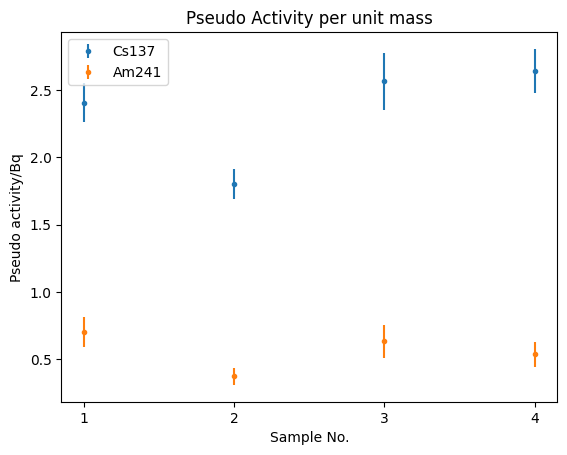

In [115]:
for nuc in ['Cs137','Am241']:
    plt.errorbar(np.arange(1,5,1),nuclide(nuc).pseudo_A
            ,yerr = nuclide(nuc).pseudo_A_err ,fmt='.',label = nuc)
    nuclide('Cs137').pseudo_A
    plt.ylabel('Pseudo activity/Bq')
    plt.xlabel('Sample No.')
    plt.title('Pseudo Activity per unit mass')
    plt.xticks(range(1,5))
    plt.legend()

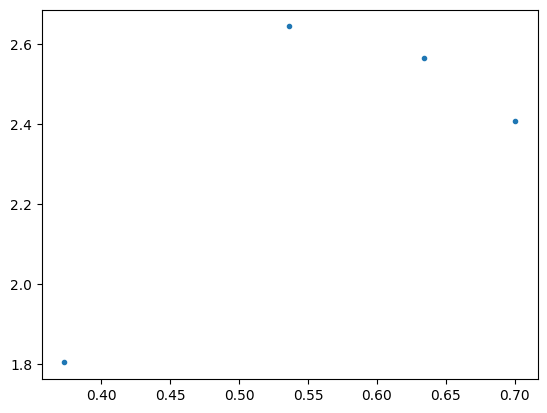

In [116]:
plt.plot(nuclide('Am241').pseudo_A,nuclide('Cs137').pseudo_A,'.')

In [126]:
df['nndc_peak_energy'].unique()

array([ 242.47  ,  295.224 ,  351.932 ,  609.321 ,  768.36  ,  803.06  ,
        934.5   , 1120.294 , 1238.122 , 1377.669 , 1407.988 , 1460.82  ,
       1509.211 , 1661.274 , 1729.595 , 1764.491 , 1847.433 , 2118.513 ,
       2204.1   , 2447.69  , 2614.511 ,   59.5409,   63.29  ,   74.815 ,
         77.107 ,   92.8   ,  100.41  ,  106.17  ,  129.065 ,  153.977 ,
        186.211 ,  209.253 ,  238.632 ,  270.245 ,  277.371 ,  300.087 ,
        328.    ,  338.32  ,  409.462 ,  463.004 ,  583.187 ,  661.657 ,
        665.446 ,  727.33  ,  755.315 ,  772.3279,  786.39  ,  794.947 ,
        835.71  ,  840.377 ,  860.557 ,  911.204 ,  964.766 ,  968.971 ,
       1001.03  , 1155.21  , 1280.976 , 1588.2   , 1620.5   , 1630.627 ,
         89.807 , 1385.31  , 1401.515 ,  332.37  ])

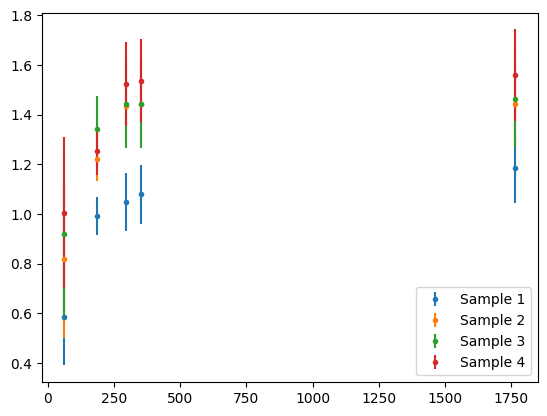

In [135]:
U238_E = [63.29, 1001.030, 186.211,351.932 ,295.224, 1764.491 ]
U238_df = df[df['nndc_peak_energy'].isin(U238_E)]
for i in range(4):
    plt.errorbar(U238_df.loc[i+1]['nndc_peak_energy'],U238_df.loc[i+1]['pseudo_A'],
    yerr= U238_df.loc[i+1]['pseudo_A_err'], fmt = '.', label = f'Sample {i+1}')
    plt.legend()

In [138]:
U238_df['Peak_CPS_BR']

0  1     0.008901
   2     0.007315
   15    0.004749
1  1     0.014001
   9     0.138093
   15    0.057948
   19    0.053539
   39    0.045557
   53    0.021842
2  1     0.019551
   8     0.169819
   14    0.076037
   18    0.069110
   36    0.025222
   52    0.025584
3  1     0.022006
   9     0.187100
   15    0.076427
   19    0.069127
   39    0.030682
   53    0.025876
4  1     0.024050
   9     0.174327
   15    0.080130
   19    0.073177
   39    0.037942
   53    0.027260
5  1     0.034327
   9     0.158030
   15    0.059421
   20    0.053597
   41    0.030945
   55    0.018903
Name: Peak_CPS_BR, dtype: float64

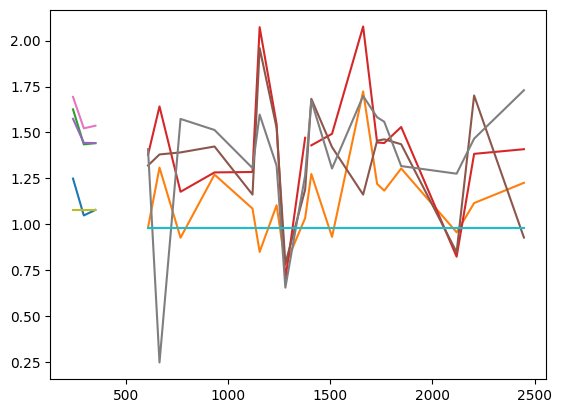

In [123]:
for i in range(5):
    pb214 = df[df['Nuclide']=='Pb214'].loc[i+1]
    bi214 = df[df['Nuclide']=='Bi214'].loc[i+1]
    plt.plot(pb214['nndc_peak_energy'],pb214['pseudo_A'])
    plt.plot(bi214['nndc_peak_energy'],bi214['pseudo_A'])

In [124]:
bi214[['nndc_peak_energy','Peak_CPS_BR_corr','BR']]

,nndc_peak_energy,Peak_CPS_BR_corr,BR
24,609.321,0.026807,0.45440
26,665.446,0.025584,0.01540
29,768.360,0.022709,0.04889
38,934.500,0.018648,0.03094
42,1120.294,0.019018,0.14900
43,1155.210,0.021335,0.01634
44,1238.122,0.016942,0.05830
45,1280.976,0.026372,0.01435
46,1377.669,0.017918,0.03985
47,1407.988,0.010820,0.02388
